In [216]:
import funciones as fun
import featureeEng as fe
import pandas as pd
import lightgbm as lgb
import warnings
import matplotlib.pyplot as plt
import numpy as np


In [217]:
sell = pd.read_csv('data/sell-in.txt', sep='\t')
products = pd.read_csv('data/tb_productos.txt', sep='\t')
lista_780 = pd.read_csv('data\productos_a_predecir.txt', sep='\t')

In [240]:
# ver cuantos productos dejo afuera

# Paso 1: productos con pocos meses (4 o menos)
conteo_por_producto = sell.groupby('product_id').size()
productos_con_pocos_meses = conteo_por_producto[conteo_por_producto <= 100].index

# Paso 2: productos cuyo último periodo < ago 2019
# Asegurate de que 'period' esté en formato entero (yyyymm)
#sell['periodo'] = sell['periodo'].astype(int)

# Obtener el último periodo por producto
ultimo_periodo = sell.groupby('product_id')['periodo'].max()

# Filtrar los que tienen último periodo < 201908
productos_con_periodo_antiguo = ultimo_periodo[ultimo_periodo < 201908].index

# Paso 3: Intersección: productos que cumplen ambas condiciones
productos_filtrados = set(productos_con_pocos_meses).intersection(productos_con_periodo_antiguo)

# Paso 4: Convertir a lista si lo necesitás
lista_nuevos = list(productos_filtrados)

sell_filtrado = sell[~sell['product_id'].isin(lista_nuevos)]

train=fun.crear_dataset(sell_filtrado,products)

In [241]:
model = lgb.LGBMRegressor(

num_leaves= 94,
learning_rate= 0.015293495120602733,
n_estimators= 967,
min_data_in_leaf= 8,
reg_alpha= 12.32,
reg_lambda= 12.32,

feature_fraction= 0.730906609846672,
bagging_fraction= 0.6955968409148202,
bagging_freq= 2,
min_split_gain= 0.5826709316464246,
random_state=42
)

In [242]:
# Crear features en train

warnings.filterwarnings('ignore')
X_train,y_train,X_val,y_val,X_octubre =fun.crear_set_entrenamiento(train)
fun.comparar_columnas(X_train,X_val)


X_train=fe.crear_features_train_lags(X_train)
X_train = fe.agregar_features_train(X_train)
X_train=fe.calcular_brecha_por_periodo(X_train)


X_train=fe.calcular_maximos_acumulados(X_train)

X_train = fe.create_elasticity_features_accelerated(
    X_train, 
    window_size=6,
    use_gpu=False  
)




Train inc dolar: (34443, 609)
X_train con todas las stats: (29715, 642)
X_train con todas las stats: (32056, 643)
Columnas solo en df1: 0

Columnas solo en df2: 0
Iniciando creación completa de features...
DataFrame inicial: (29715, 722)
Procesando cliente_10001...
Procesando cliente_10002...
Procesando cliente_10003...
Procesando cliente_10004...
Procesando cliente_10005...
Procesando cliente_10006...
Procesando cliente_10007...
Procesando cliente_10008...
Procesando cliente_10009...
Procesando cliente_10010...
Procesando cliente_10011...
Procesando cliente_10012...
Procesando cliente_10013...
Procesando cliente_10014...
Procesando cliente_10015...
Procesando cliente_10016...
Procesando cliente_10017...
Procesando cliente_10018...
Procesando cliente_10019...
Procesando cliente_10020...
Procesando cliente_10021...
Procesando cliente_10022...
Procesando cliente_10023...
Procesando cliente_10024...
Procesando cliente_10025...
Creando medias móviles...
Creando desvíos móviles...
Creando 

In [243]:
warnings.filterwarnings('ignore')

X_val=fe.crear_features_train_lags(X_octubre)
X_val = fe.agregar_features_train(X_val)
X_val=fe.calcular_brecha_por_periodo(X_val)



X_val=fe.calcular_maximos_acumulados(X_val)
X_val = fe.agregar_features_train(X_val)

X_val = fe.create_elasticity_features_accelerated(
    X_val, 
    window_size=6,
    use_gpu=False  
)


X_val = X_val[X_val['periodo'] == 201910]


Iniciando creación completa de features...
DataFrame inicial: (32056, 722)
Procesando cliente_10001...
Procesando cliente_10002...
Procesando cliente_10003...
Procesando cliente_10004...
Procesando cliente_10005...
Procesando cliente_10006...
Procesando cliente_10007...
Procesando cliente_10008...
Procesando cliente_10009...
Procesando cliente_10010...
Procesando cliente_10011...
Procesando cliente_10012...
Procesando cliente_10013...
Procesando cliente_10014...
Procesando cliente_10015...
Procesando cliente_10016...
Procesando cliente_10017...
Procesando cliente_10018...
Procesando cliente_10019...
Procesando cliente_10020...
Procesando cliente_10021...
Procesando cliente_10022...
Procesando cliente_10023...
Procesando cliente_10024...
Procesando cliente_10025...
Creando medias móviles...
Creando desvíos móviles...
Creando medianas móviles...
Creando features temporales...
Creando incrementos por períodos...
Creando lags manuales...
Creando features de incrementos específicos...
🔍 DET

In [244]:
# Llenar con nan nuevas columnas en de X_val en train

solo_en_df1, solo_en_df2, comunes=fun.comparar_columnas(X_train, X_val, "X_train", "X_val")
for col in solo_en_df2:
   X_train[col] = np.nan
   
   


Columnas solo en X_train: 0

Columnas solo en X_val: 48
['elasticity_21216', 'elasticity_20995', 'elasticity_20964', 'elasticity_21026', 'elasticity_20992', 'elasticity_20436', 'elasticity_20437', 'elasticity_20764', 'elasticity_20993', 'elasticity_21219']


In [245]:
# Canarios y categorias

X_train=fun.canaritos(X_train,1018)
X_val=fun.canaritos(X_val,1018)

X_train=fun.categorizar(X_train)
X_val=fun.categorizar(X_val)


In [246]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
model_1, r2_score = fe.entrenar_modelo_lgbm(model,X_train,y_train,X_val,y_val)

[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.730906609846672, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.730906609846672
[LightGBM] [Warning] bagging_fraction is set=0.6955968409148202, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6955968409148202
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.730906609846672, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.730906609846672
[LightGBM] [Warning] bagging_fraction is set=0.6955968409148202, subsample=1.0 will be ignored. Current value: bagging_fr

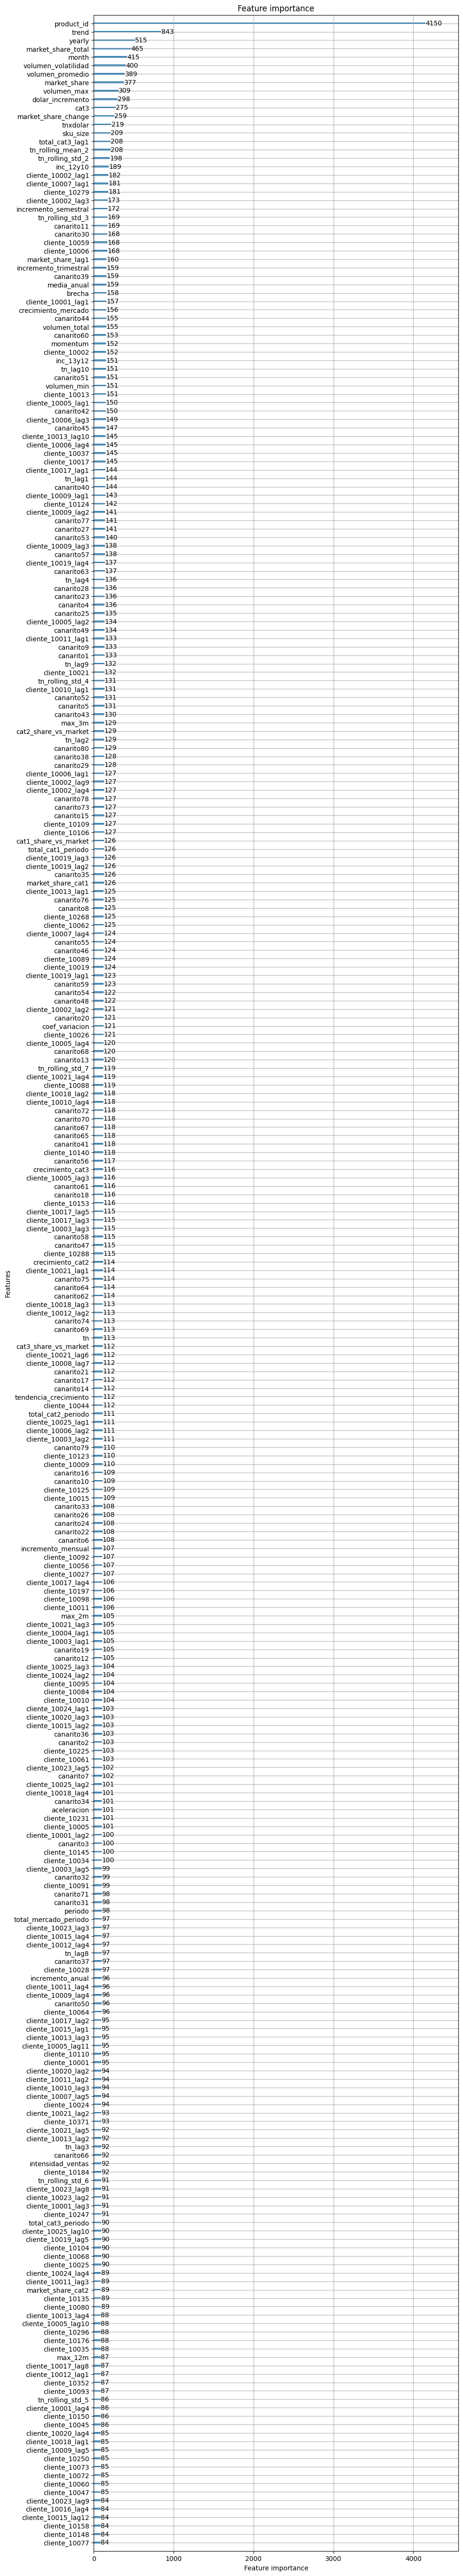

In [286]:
lgb.plot_importance(model_1, max_num_features=300, figsize=(10, 70))
plt.show()

In [314]:
#Definir el punto de corte
features_disponibles=fe.podar(60,model_1.feature_importances_,X_train,X_val)

In [315]:
# 7. Crear datasets podados
if len(features_disponibles) > 0:
    X_train_podado = X_train[features_disponibles]
    X_val_podado = X_val[features_disponibles]
    print(f"Datasets podados creados: {X_train_podado.shape}, {X_val_podado.shape}")
else:
    print("No hay features válidas para podar")

Datasets podados creados: (29715, 377), (1190, 377)


In [316]:
model_podado = lgb.LGBMRegressor(
    
num_leaves= 94,
learning_rate= 0.015293495120602733,
n_estimators= 967,
min_data_in_leaf= 8,
reg_alpha= 20,
reg_lambda= 125,

feature_fraction= 0.730906609846672,
bagging_fraction= 0.6955968409148202,
bagging_freq= 2,
min_split_gain= 0.5826709316464246,
random_state=42  


)

#max_bin= 98837, 

In [16]:
#from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
#model_podado,X_train_podado,y_train,X_val_podado,y_val,y_pred_podado,X_train,feature_importance_podado,features_disponibles=fe.entrenar_modelo_podado_lgbm(model,X_train_podado,y_train,X_val_podado,y_val,X_train,features_disponibles)

In [317]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
print("Entrenando modelo podado...")

model_podado.fit(X_train_podado, y_train)
y_pred_podado = model_podado.predict(X_val_podado)

# Comparar métricas
r2_podado = r2_score(y_val, y_pred_podado)
rmse_podado = np.sqrt(mean_squared_error(y_val, y_pred_podado))
mae_podado = mean_absolute_error(y_val, y_pred_podado)

print(f"\n=== MODELO PODADO (features) ===")
print(f"R2: {r2_podado:.4f}")
print(f"RMSE: {rmse_podado:.4f}")
print(f"MAE: {mae_podado:.4f}")

# Feature importance del modelo podado
feature_importance_podado = model_podado.feature_importances_
print(f"\n=== FEATURE IMPORTANCE MODELO PODADO ===")
for i, feature in enumerate(features_disponibles):
    print(f"{feature}: {feature_importance_podado[i]:.0f}")


# Si quieres comparar con el modelo original
print(f"\n=== COMPARACIÓN ===")
print(f"Features: Original {X_train.shape[1]} → Podado {X_train_podado.shape[1]}")

Entrenando modelo podado...
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.730906609846672, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.730906609846672
[LightGBM] [Warning] bagging_fraction is set=0.6955968409148202, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6955968409148202
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.730906609846672, colsample_bytree=1.0 will be i

In [319]:
fun.forecast_error(y_val,y_pred_podado)

Total Forecast Error: 0.2937
Total Forecast Error (%): 29.37%


In [320]:
# Obtener la lista de productos
productos_a_predecir = lista_780['product_id'].tolist()

# Filtrar y_val y y_pred solo para esos productos
mask_productos = X_val['product_id'].isin(productos_a_predecir)

# Usar .values para convertir a numpy array
y_val_filtrado = y_val.values[mask_productos]
y_pred_filtrado = y_pred_podado[mask_productos]

# Calcular forecast error solo para esa lista
total_forecast_error = np.sum(np.abs(y_val_filtrado - y_pred_filtrado)) / np.sum(y_val_filtrado)

print(f"Productos en la lista: {len(productos_a_predecir)}")
print(f"Productos encontrados: {mask_productos.sum()}")
print(f"Total Forecast Error (lista específica): {total_forecast_error * 100:.2f}%")

# Comparar con forecast error general
forecast_error_general = np.sum(np.abs(y_val - y_pred_podado)) / np.sum(y_val)
print(f"Total Forecast Error (general): {forecast_error_general * 100:.2f}%")

Productos en la lista: 780
Productos encontrados: 780
Total Forecast Error (lista específica): 25.23%
Total Forecast Error (general): 29.37%


definir una funcion de corte que minimize el error

In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from typing import List, Tuple, Dict
import matplotlib.pyplot as plt

def buscar_corte_optimo(
    valores_corte: List[int],
    feature_importances: np.ndarray,
    X_train: pd.DataFrame,
    X_val: pd.DataFrame,
    y_train: pd.Series,
    y_val: pd.Series,
    model_params: dict,
    fe_module,  # tu módulo fe
    fun_module,  # tu módulo fun
    productos_filtro: List = None,
    verbose: bool = True
) -> Dict:
    """
    Busca el valor de corte óptimo para feature selection probando diferentes valores
    
    Parameters:
    -----------
    valores_corte : List[int]
        Lista de valores de corte a probar (ej: [10, 20, 30, 40, 50, 60, 70])
    feature_importances : np.ndarray
        Importancias de features del modelo base
    X_train, X_val : pd.DataFrame
        Datasets de entrenamiento y validación
    y_train, y_val : pd.Series
        Targets de entrenamiento y validación
    model_params : dict
        Parámetros del modelo LightGBM
    fe_module : module
        Tu módulo fe con funciones podar() y entrenar_modelo_podado_lgbm()
    fun_module : module
        Tu módulo fun con función forecast_error()
    productos_filtro : List, optional
        Lista de product_ids para calcular error específico
    verbose : bool
        Si mostrar progreso detallado
    
    Returns:
    --------
    Dict con resultados de la búsqueda
    """
    
    resultados = {
        'valor_corte': [],
        'num_features': [],
        'forecast_error_general': [],
        'forecast_error_filtrado': [],
        'r2': [],
        'rmse': [],
        'mae': [],
        'features_seleccionadas': []
    }
    
    mejor_error = float('inf')
    mejor_corte = None
    mejor_modelo = None
    mejor_features = None
    
    print("="*80)
    print("BÚSQUEDA DE VALOR DE CORTE ÓPTIMO PARA FEATURE SELECTION")
    print("="*80)
    
    for corte in valores_corte:
        if verbose:
            print(f"\n🔍 Probando valor de corte: {corte}")
        
        try:
            # 1. Podar features
            features_disponibles = fe_module.podar(corte, feature_importances, X_train, X_val)
            
            if len(features_disponibles) == 0:
                if verbose:
                    print(f"❌ No hay features válidas para corte {corte}")
                continue
            
            # 2. Crear datasets podados
            X_train_podado = X_train[features_disponibles]
            X_val_podado = X_val[features_disponibles]
            
            if verbose:
                print(f"📊 Features seleccionadas: {len(features_disponibles)}")
            
            # 3. Crear y entrenar modelo
            model = lgb.LGBMRegressor(**model_params)
            
            model_podado, X_train_podado, y_train_out, X_val_podado, y_val_out, y_pred_podado, X_train_out, feature_importance_podado, features_disponibles_out = fe_module.entrenar_modelo_podado_lgbm(
                model, X_train_podado, y_train, X_val_podado, y_val, X_train, features_disponibles
            )
            
            # 4. Calcular métricas generales
            error_metrics = fun_module.forecast_error(y_val, y_pred_podado)
            
            # 5. Calcular error filtrado si se especifica lista de productos
            error_filtrado = None
            if productos_filtro is not None:
                mask_productos = X_val['product_id'].isin(productos_filtro)
                y_val_filtrado = y_val.values[mask_productos]
                y_pred_filtrado = y_pred_podado[mask_productos]
                
                if len(y_val_filtrado) > 0:
                    error_filtrado = np.sum(np.abs(y_val_filtrado - y_pred_filtrado)) / np.sum(y_val_filtrado)
                else:
                    error_filtrado = float('inf')
            
            # 6. Almacenar resultados
            resultados['valor_corte'].append(corte)
            resultados['num_features'].append(len(features_disponibles))
            
            # Extraer métricas (asumiendo que forecast_error devuelve un dict o valores)
            if isinstance(error_metrics, dict):
                resultados['forecast_error_general'].append(error_metrics.get('total_error', float('inf')))
                resultados['r2'].append(error_metrics.get('r2', -float('inf')))
                resultados['rmse'].append(error_metrics.get('rmse', float('inf')))
                resultados['mae'].append(error_metrics.get('mae', float('inf')))
            else:
                # Si forecast_error solo devuelve el error total
                resultados['forecast_error_general'].append(error_metrics if error_metrics is not None else float('inf'))
                resultados['r2'].append(-float('inf'))
                resultados['rmse'].append(float('inf'))
                resultados['mae'].append(float('inf'))
            
            resultados['forecast_error_filtrado'].append(error_filtrado if error_filtrado is not None else float('inf'))
            resultados['features_seleccionadas'].append(features_disponibles.copy())
            
            # 7. Determinar si es el mejor modelo
            error_objetivo = error_filtrado if error_filtrado is not None else resultados['forecast_error_general'][-1]
            
            if error_objetivo < mejor_error:
                mejor_error = error_objetivo
                mejor_corte = corte
                mejor_modelo = model_podado
                mejor_features = features_disponibles.copy()
            
            if verbose:
                print(f"✅ Error general: {resultados['forecast_error_general'][-1]:.4f}")
                if error_filtrado is not None:
                    print(f"✅ Error filtrado: {error_filtrado:.4f}")
                print(f"📈 R²: {resultados['r2'][-1]:.4f}")
        
        except Exception as e:
            if verbose:
                print(f"❌ Error en corte {corte}: {str(e)}")
            continue
    
    # Crear DataFrame con resultados
    df_resultados = pd.DataFrame(resultados)
    
    # Encontrar el mejor resultado
    if productos_filtro is not None:
        idx_mejor = df_resultados['forecast_error_filtrado'].idxmin()
        metrica_objetivo = 'forecast_error_filtrado'
    else:
        idx_mejor = df_resultados['forecast_error_general'].idxmin()
        metrica_objetivo = 'forecast_error_general'
    
    mejor_resultado = df_resultados.iloc[idx_mejor]
    
    print("\n" + "="*80)
    print("RESULTADOS DE LA BÚSQUEDA")
    print("="*80)
    print(f"🏆 MEJOR VALOR DE CORTE: {mejor_resultado['valor_corte']}")
    print(f"📊 Features seleccionadas: {mejor_resultado['num_features']}")
    print(f"🎯 Error objetivo: {mejor_resultado[metrica_objetivo]:.6f}")
    print(f"📈 R²: {mejor_resultado['r2']:.4f}")
    print(f"📉 RMSE: {mejor_resultado['rmse']:.4f}")
    print(f"📉 MAE: {mejor_resultado['mae']:.4f}")
    
    # Mostrar tabla resumen
    print("\n📋 RESUMEN DE TODOS LOS VALORES PROBADOS:")
    columnas_mostrar = ['valor_corte', 'num_features', 'forecast_error_general']
    if productos_filtro is not None:
        columnas_mostrar.append('forecast_error_filtrado')
    columnas_mostrar.extend(['r2', 'rmse', 'mae'])
    
    print(df_resultados[columnas_mostrar].round(6))
    
    return {
        'mejor_corte': int(mejor_resultado['valor_corte']),
        'mejor_error': mejor_resultado[metrica_objetivo],
        'mejor_features': mejor_features,
        'mejor_modelo': mejor_modelo,
        'df_resultados': df_resultados,
        'metrica_objetivo': metrica_objetivo
    }


In [ ]:
"""
# Definir valores a probar (incluyendo tu 35 actual)
valores_a_probar = [50,60,70,80,90,100,110,120]

# Ejecutar búsqueda
resultado = buscar_corte_optimo(
    valores_corte=valores_a_probar,
    feature_importances=model_1.feature_importances_,
    X_train=X_train,
    X_val=X_val,
    y_train=y_train,
    y_val=y_val,
    model_params={
        'num_leaves': 94,
        'learning_rate': 0.015293495120602733,
        'n_estimators': 967,
        'min_data_in_leaf': 8,
        'reg_alpha': 12.320557276828628,
        'reg_lambda': 12.320557276828628,
        'feature_fraction': 0.730906609846672,
        'bagging_fraction': 0.6955968409148202,
        'bagging_freq': 2,
        'min_split_gain': 0.5826709316464246,
        'max_bin': 98837, 
        'random_state': 42
    },
    fe_module=fe,
    fun_module=fun,
    productos_filtro=lista_780['product_id'].tolist()
)

# Usar el mejor resultado
mejor_corte = resultado['mejor_corte']
print(f"🏆 Mejor valor de corte: {mejor_corte}")
"""

BÚSQUEDA DE VALOR DE CORTE ÓPTIMO PARA FEATURE SELECTION

🔍 Probando valor de corte: 50
📊 Features seleccionadas: 598
Entrenando modelo podado...
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.730906609846672, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.730906609846672
[LightGBM] [Warning] bagging_fraction is set=0.6955968409148202, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6955968409148202
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.730906609846672, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.730906609846672
[LightGBM] [Warning] bagging_fraction is set=0.69559684

KeyboardInterrupt: 

# Preparar el entrenamiento final

In [254]:
def crear_train_final(train):    
    train_2=fun.agregar_dolar(train)
    train_2 = fun.crear_variables_politicas(train_2)
    #clusters = pd.read_csv("clusters/cluster_dtw_qv_octubre/cluster_assignments_20250731_002450.csv", sep=',') # verrrr -----
    #train_final=fun.crear_clusters_dtw(clusters,train_2) 
    
    
    
    clusters = pd.read_csv("clusters/hierarchical_results_octubre_50.csv", sep=',') 
    train_final=fun.crear_clustes_jerarquicos(clusters,train_2) 
    
    mascara=201910  

    X_final,y_final=fe.crear_particicion_final(train_final,mascara)
    X_final,stats=fun.crear_ciclo_de_vida_producto(X_final)


    X_final = X_final.drop('descripcion', axis=1, errors='ignore')
    X_final = X_final.drop('ultimo_periodo_dataset', axis=1, errors='ignore')

    prophet_train = pd.read_csv("prophet/ph_octubre_train.csv", sep=',')
    X_final=fun.agregar_prophet_train(prophet_train,X_final)
    
    return X_final,y_final

In [ ]:
#features_disponibles=resultado['mejor_features']

In [255]:
#Generar X_final

X_final,y_final=crear_train_final(train)
X_final=fun.categorizar(X_final)

X_final=fe.crear_features_train_lags(X_final)

X_final = fe.agregar_features_train(X_final)

X_final=fe.calcular_brecha_por_periodo(X_final)




X_final=fe.calcular_maximos_acumulados(X_final)
X_final = fe.create_elasticity_features_accelerated(
    X_final, 
    window_size=6,
    use_gpu=False  
)




Train inc dolar: (34443, 609)
X_train con todas las stats: (32056, 642)
Iniciando creación completa de features...
DataFrame inicial: (32056, 642)
Procesando cliente_10001...
Procesando cliente_10002...
Procesando cliente_10003...
Procesando cliente_10004...
Procesando cliente_10005...
Procesando cliente_10006...
Procesando cliente_10007...
Procesando cliente_10008...
Procesando cliente_10009...
Procesando cliente_10010...
Procesando cliente_10011...
Procesando cliente_10012...
Procesando cliente_10013...
Procesando cliente_10014...
Procesando cliente_10015...
Procesando cliente_10016...
Procesando cliente_10017...
Procesando cliente_10018...
Procesando cliente_10019...
Procesando cliente_10020...
Procesando cliente_10021...
Procesando cliente_10022...
Procesando cliente_10023...
Procesando cliente_10024...
Procesando cliente_10025...
Creando medias móviles...
Creando desvíos móviles...
Creando medianas móviles...
Creando features temporales...
Creando incrementos por períodos...
Crea

In [324]:
X_final_podado = X_final[features_disponibles]


In [331]:
# Modelo final


model_final_podado = lgb.LGBMRegressor(

num_leaves= 94,
learning_rate= 0.015293495120602733,
n_estimators= 967,
min_data_in_leaf= 14,
reg_alpha= 20,
reg_lambda= 300,

feature_fraction= 0.730906609846672,
bagging_fraction= 0.6955968409148202,
bagging_freq= 2,
min_split_gain= 0.5826709316464246,
random_state=42
)


#max_bin= 98837, 
#sample_weights = X_final_podado['tn_lag10']
#,sample_weight=sample_weights

print(f"\nEntrenando modelo final podado ({len(features_disponibles)} features)...")
model_final_podado.fit(X_final_podado, y_final)


print("✅ Modelo final podado entrenado!")
print(f"Features finales: {features_disponibles}")


Entrenando modelo final podado (377 features)...
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] feature_fraction is set=0.730906609846672, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.730906609846672
[LightGBM] [Warning] bagging_fraction is set=0.6955968409148202, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6955968409148202
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] feature_fraction is set=0.730906609846672, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.730906609846672
[LightGBM] [Warning] bagging_fraction is set=0.6955968409148202, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6955968409148202


In [258]:


X_diciembre=fe.crear_diciembre(train)
X_diciembre=fun.crear_variables_politicas(X_diciembre)  # agregar a crear dic
X_diciembre=fun.categorizar(X_diciembre)

X_diciembre = fe.agregar_features_train(X_diciembre)
X_diciembre=fe.crear_features_train_lags(X_diciembre)

X_diciembre=fe.calcular_brecha_por_periodo(X_diciembre)





X_diciembre=fe.calcular_maximos_acumulados(X_diciembre)
X_diciembre = fe.agregar_features_train(X_diciembre)


X_diciembre = fe.create_elasticity_features_accelerated(
    X_diciembre, 
    window_size=6,
    use_gpu=False  
)


X_diciembre = X_diciembre[X_diciembre['periodo'] == 201912]
X_diciembre = X_diciembre.drop('clase', axis=1)




Train inc dolar: (34443, 609)
X_train con todas las stats: (34443, 638)
Iniciando creación completa de features...
DataFrame inicial: (34443, 680)
Procesando cliente_10001...
Procesando cliente_10002...
Procesando cliente_10003...
Procesando cliente_10004...
Procesando cliente_10005...
Procesando cliente_10006...
Procesando cliente_10007...
Procesando cliente_10008...
Procesando cliente_10009...
Procesando cliente_10010...
Procesando cliente_10011...
Procesando cliente_10012...
Procesando cliente_10013...
Procesando cliente_10014...
Procesando cliente_10015...
Procesando cliente_10016...
Procesando cliente_10017...
Procesando cliente_10018...
Procesando cliente_10019...
Procesando cliente_10020...
Procesando cliente_10021...
Procesando cliente_10022...
Procesando cliente_10023...
Procesando cliente_10024...
Procesando cliente_10025...
Creando medias móviles...
Creando desvíos móviles...
Creando medianas móviles...
Creando features temporales...
Creando incrementos por períodos...
Crea

In [332]:
X_diciembre_podado=X_diciembre[features_disponibles]

predicciones_febrero = model_final_podado.predict(X_diciembre_podado)

[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] feature_fraction is set=0.730906609846672, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.730906609846672
[LightGBM] [Warning] bagging_fraction is set=0.6955968409148202, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6955968409148202
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


In [333]:
resultados_finales = pd.DataFrame({
   'product_id': X_diciembre['product_id'],
   'tn_diciembre_real': X_diciembre['tn'],
   'tn_febrero_predicho': predicciones_febrero,
   'ratio_crecimiento': predicciones_febrero / X_diciembre['tn']
})


productos_a_predecir = lista_780['product_id'].tolist()


# Filtrar solo productos de tu lista
predicciones = resultados_finales[
   resultados_finales['product_id'].isin(productos_a_predecir)
][['product_id', 'tn_febrero_predicho']].copy()

# Renombrar columna
predicciones = predicciones.rename(columns={'tn_febrero_predicho': 'tn'})

print(f"Dataset predicciones creado:")
print(f"  Productos en lista: {len(productos_a_predecir)}")
print(f"  Productos encontrados: {len(predicciones)}")
print(f"  Productos faltantes: {len(productos_a_predecir) - len(predicciones)}")

print(f"\nPrimeros 10 registros:")
print(predicciones.head(10))

print(f"\nEstructura final:")
print(f"Columnas: {list(predicciones.columns)}")
print(f"Shape: {predicciones.shape}")

Dataset predicciones creado:
  Productos en lista: 780
  Productos encontrados: 780
  Productos faltantes: 0

Primeros 10 registros:
       product_id           tn
33246       20001  1148.316558
33247       20002  1108.554568
33248       20003   861.104611
33249       20004   499.324858
33250       20005   532.463479
33251       20006   426.601811
33252       20007   319.461143
33253       20008   325.415001
33254       20009   485.785132
33255       20010   321.025584

Estructura final:
Columnas: ['product_id', 'tn']
Shape: (780, 2)


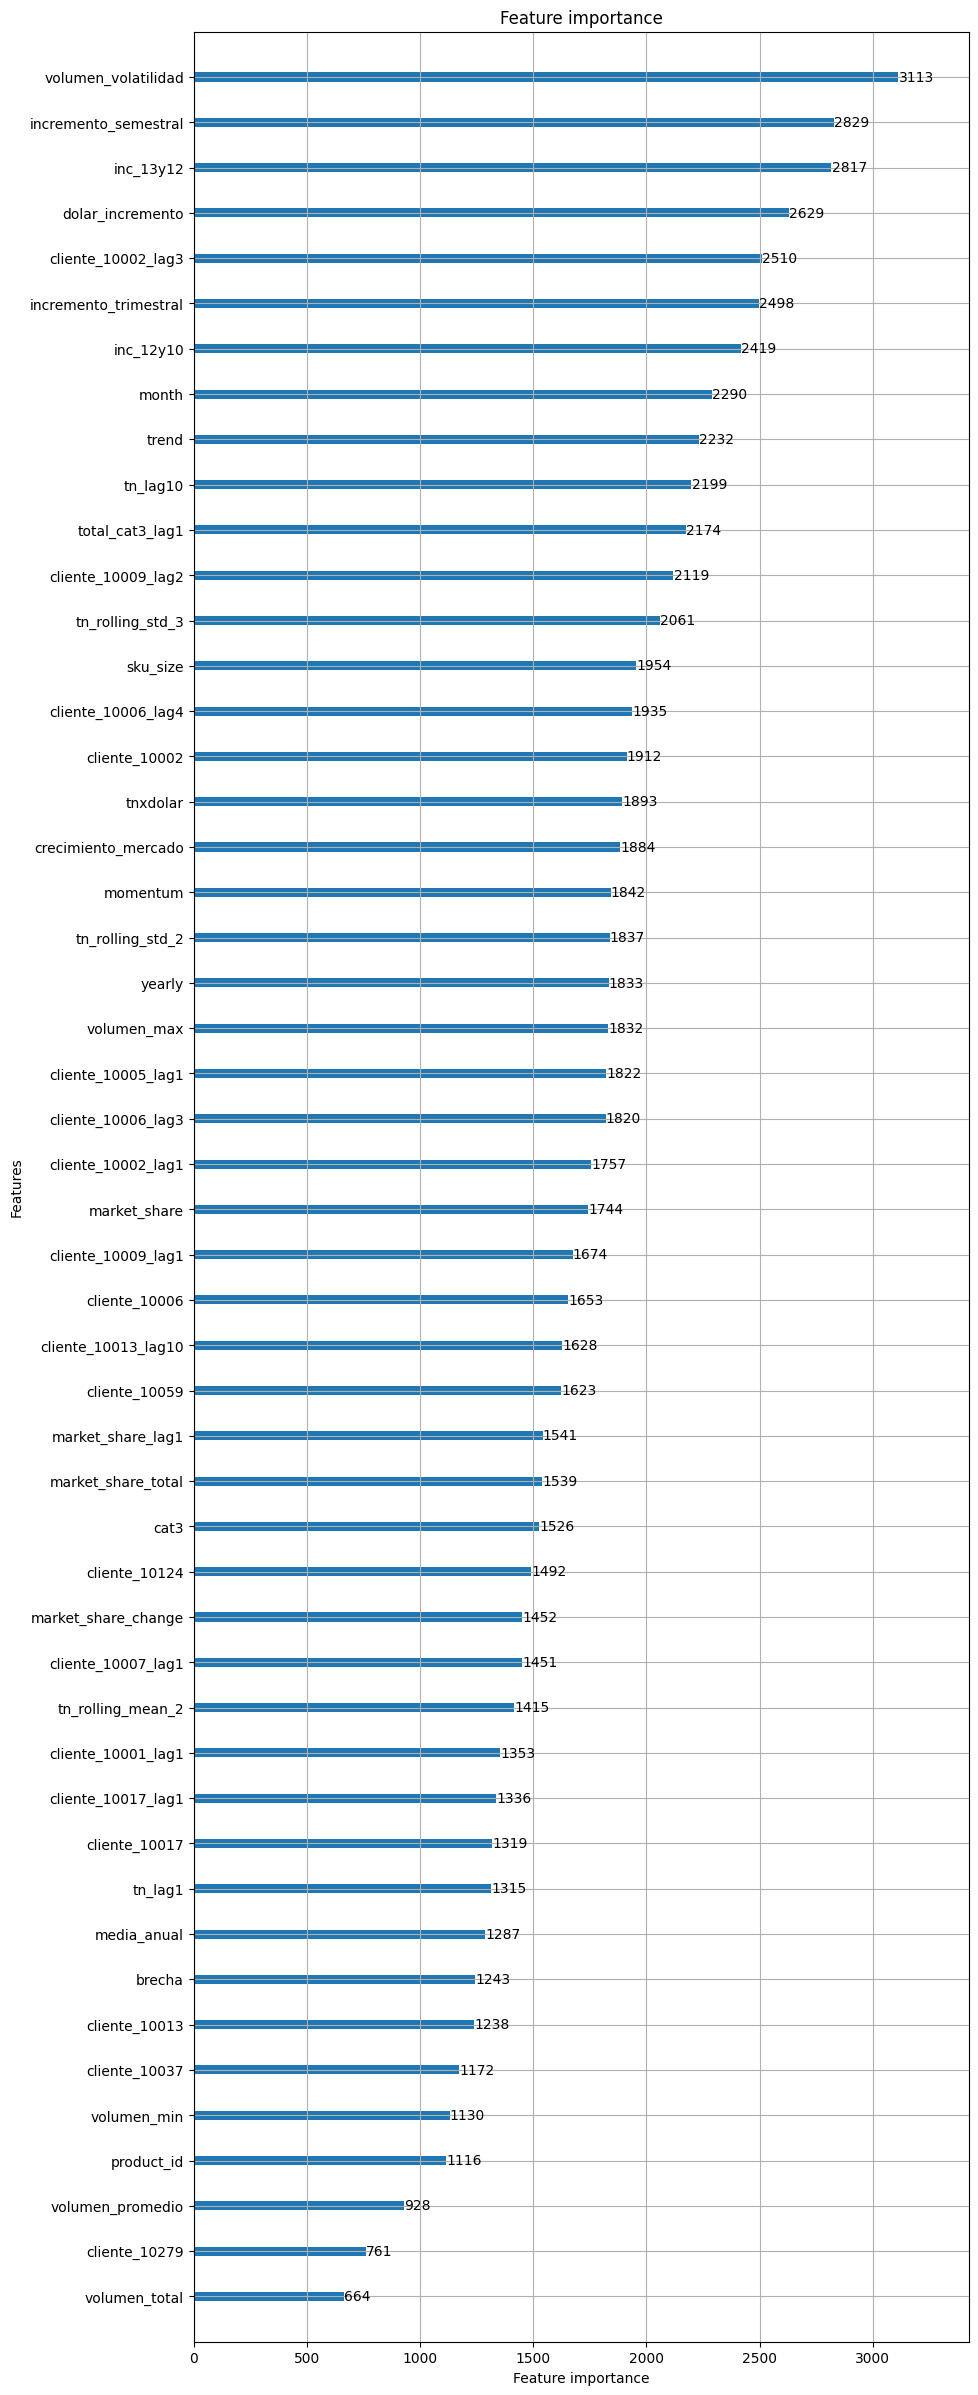

In [297]:
lgb.plot_importance(model_final_podado, max_num_features=186, figsize=(10, 30))
plt.show()

In [284]:
predicciones.to_csv("lgbm_product_completo_150_20_125.csv",index=False)

In [285]:
predicciones

,product_id,tn
33246,20001,1257.402077
33247,20002,1092.312229
33248,20003,837.987362
33249,20004,443.178607
33250,20005,522.202118
...,...,...
34434,21263,0.316529
34436,21265,0.368282
34437,21266,0.327965
34438,21267,0.483862


In [283]:
predicciones[predicciones['product_id'] == 20032]

,product_id,tn
33277,20032,202.945522


In [ ]:
## Semillerio 

In [215]:
import numpy as np
import random
import tensorflow as tf  # si usas TF
from sklearn.ensemble import RandomForestRegressor

# Semilla maestra para generar las 100 semillas
MASTER_SEED = 42

# Generar las 100 semillas de forma reproducible
np.random.seed(MASTER_SEED)
seeds = np.random.randint(0, 10000, size=100)
# Esto SIEMPRE generará las mismas 100 semillas

print(f"Semillas: {seeds[:10]}...")  # Ej: [8823, 9116, 7560, ...]
#X_filtrado = X_diciembre_podado[X_diciembre_podado['product_id'].isin(productos_a_predecir)]
#y_filtrado = y[X_diciembre_podado['product_id'].isin(productos_a_predecir)]
#X_final_podado = X_final_podado [X_final_podado ['product_id'].isin(productos_a_predecir)]
predictions = []

for i, seed in enumerate(seeds):
    
    print(f"Ejecutando semilla {i+1}/100: {seed}")
    model_final_podado = lgb.LGBMRegressor(
      random_state=seed,
      
      num_leaves= 94,
      learning_rate= 0.015293495120602733,
      n_estimators= 967,
      min_data_in_leaf= 8,
      reg_alpha= 20,
      reg_lambda= 350,

      feature_fraction= 0.730906609846672,
      bagging_fraction= 0.6955968409148202,
      bagging_freq= 2,
      min_split_gain= 0.5826709316464246,

      
      
    )
    #reg_alpha=0.5908535234309166,
    #reg_lambda=0.5338675724375266,
    #, sample_weight=np.log1p(X_final_podado['tn'])

  
    model_final_podado.fit(X_final_podado, y_final)
    
    pred = model_final_podado.predict(X_diciembre_podado )
    predictions.append(pred)
    
  
  
final_prediction = np.mean(predictions, axis=0)
idx=X_diciembre_podado['product_id'].to_list()
results_df = pd.DataFrame({
    'product_id': idx,
    'tn': final_prediction
})
results_df

predicciones_semillerio = results_df[
   results_df['product_id'].isin(productos_a_predecir)
][['product_id', 'tn']].copy()    
predicciones_semillerio.to_csv("lgbm_product_20_350_sem.csv",index=False)    

predicciones_semillerio
    

Semillas: [7270  860 5390 5191 5734 6265  466 4426 5578 8322]...
Ejecutando semilla 1/100: 7270
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.730906609846672, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.730906609846672
[LightGBM] [Warning] bagging_fraction is set=0.6955968409148202, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6955968409148202
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=0.730906609846672, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.730906609846672
[LightGBM] [Warning] bagging_fraction is set=0.6955968409148202, subsample=1.0 will be ignored. Current v

,product_id,tn
0,20001,1114.205122
1,20002,1081.592950
2,20003,786.988161
3,20004,506.676262
4,20005,532.344864
...,...,...
1192,21263,0.282922
1194,21265,0.296108
1195,21266,0.222656
1196,21267,0.368252


In [213]:
predicciones_semillerio[predicciones_semillerio['product_id'] == 20032]

,product_id,tn
31,20032,247.305214


In [214]:
predicciones_semillerio

,product_id,tn
0,20001,1149.532794
1,20002,1102.171939
2,20003,792.540568
3,20004,503.721570
4,20005,529.080708
...,...,...
1192,21263,0.286116
1194,21265,0.277658
1195,21266,0.220043
1196,21267,0.373307


In [ ]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_slice, plot_parallel_coordinate
import warnings
warnings.filterwarnings('ignore')

class LGBMOptunaOptimizer:
    def __init__(self, X_train, y_train, X_val=None, y_val=None, 
                 date_column=None, train_months=12, val_months=2,
                 scoring='neg_mean_squared_error', random_state=42):
        """
        Optimizador con Optuna para LGBMRegressor con validación temporal personalizada
        
        Parameters:
        -----------
        X_train : array-like or DataFrame
            Features de entrenamiento
        y_train : array-like or Series
            Target de entrenamiento
        X_val : array-like, optional
            Features de validación (si se proporciona, ignora validación temporal)
        y_val : array-like, optional
            Target de validación
        date_column : str or array-like, optional
            Columna de fechas o array de fechas para validación temporal
        train_months : int
            Número de períodos para entrenamiento en validación temporal
        val_months : int  
            Número de períodos para validación en validación temporal
        scoring : str
            Métrica para optimizar ('neg_mean_squared_error', 'neg_mean_absolute_error', 'r2')
        random_state : int
            Semilla para reproducibilidad
        """
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.date_column = date_column
        self.train_months = train_months
        self.val_months = val_months
        self.scoring = scoring
        self.random_state = random_state
        self.best_params = None
        self.best_score = None
        self.study = None
        self.best_trial = None
        self.temporal_splits = None
        
        # Si se proporciona date_column, preparar splits temporales
        if date_column is not None and X_val is None:
            self._prepare_temporal_splits()
    
    def _prepare_temporal_splits(self):
        """
        Preparar splits temporales personalizados para períodos enteros
        """
        print("Preparando validación temporal personalizada...")
        
        # Convertir a DataFrame si es necesario
        if isinstance(self.X_train, np.ndarray):
            X_df = pd.DataFrame(self.X_train)
        else:
            X_df = self.X_train.copy()
        
        if isinstance(self.y_train, np.ndarray):
            y_series = pd.Series(self.y_train)
        else:
            y_series = self.y_train.copy()
        
        # Obtener períodos
        if isinstance(self.date_column, str):
            # La columna es el nombre de una columna en X_train (ej: 'periodo')
            periods = X_df[self.date_column].values
        else:
            # Es un array/series de períodos
            periods = self.date_column
        
        # Crear DataFrame temporal para facilitar manipulación
        temp_df = pd.DataFrame({
            'periodo': periods,
            'index': range(len(periods))
        })
        temp_df = temp_df.sort_values('periodo').reset_index(drop=True)
        
        # Obtener períodos únicos (ya son enteros)
        unique_periods = sorted(temp_df['periodo'].unique())
        
        print(f"Período total: {unique_periods[0]} a {unique_periods[-1]}")
        print(f"Total de períodos disponibles: {len(unique_periods)}")
        
        # Crear splits temporales
        self.temporal_splits = []
        
        for i in range(len(unique_periods) - self.train_months - self.val_months + 1):
            # Períodos de entrenamiento (train_months períodos consecutivos)
            train_periods = unique_periods[i:i + self.train_months]
            # Períodos de validación (val_months períodos inmediatamente después)
            val_periods = unique_periods[i + self.train_months:i + self.train_months + self.val_months]
            
            # Obtener índices para entrenamiento
            train_mask = temp_df['periodo'].isin(train_periods)
            train_indices = temp_df[train_mask]['index'].values
            
            # Obtener índices para validación
            val_mask = temp_df['periodo'].isin(val_periods)
            val_indices = temp_df[val_mask]['index'].values
            
            if len(train_indices) > 0 and len(val_indices) > 0:
                self.temporal_splits.append((train_indices, val_indices))
                print(f"Split {len(self.temporal_splits)}: Train períodos {train_periods[0]} a {train_periods[-1]} | Val períodos {val_periods[0]} a {val_periods[-1]}")
        
        print(f"Total de splits temporales creados: {len(self.temporal_splits)}")
        
        if len(self.temporal_splits) == 0:
            raise ValueError(f"No se pudieron crear splits temporales. Verifica que tienes al menos {self.train_months + self.val_months} períodos de datos.")
    
    def _temporal_cross_validation(self, model):
        """
        Realizar validación cruzada temporal personalizada
        """
        scores = []
        
        for train_idx, val_idx in self.temporal_splits:
            # Obtener datos de entrenamiento y validación para este split
            if isinstance(self.X_train, pd.DataFrame):
                X_train_fold = self.X_train.iloc[train_idx]
                X_val_fold = self.X_train.iloc[val_idx]
            else:
                X_train_fold = self.X_train[train_idx]
                X_val_fold = self.X_train[val_idx]
            
            if isinstance(self.y_train, pd.Series):
                y_train_fold = self.y_train.iloc[train_idx]
                y_val_fold = self.y_train.iloc[val_idx]
            else:
                y_train_fold = self.y_train[train_idx]
                y_val_fold = self.y_train[val_idx]
            
            # Entrenar modelo
            model.fit(X_train_fold, y_train_fold)
            y_pred = model.predict(X_val_fold)
            
            # Calcular score
            if self.scoring == 'neg_mean_squared_error':
                score = -mean_squared_error(y_val_fold, y_pred)
            elif self.scoring == 'neg_mean_absolute_error':
                score = -mean_absolute_error(y_val_fold, y_pred)
            elif self.scoring == 'r2':
                score = r2_score(y_val_fold, y_pred)
            else:
                score = -mean_squared_error(y_val_fold, y_pred)
            
            scores.append(score)
        
        return np.mean(scores)
        
    def objective(self, trial):
        """
        Función objetivo para Optuna
        """
        # Definir el espacio de búsqueda
        params = {
            'num_leaves': trial.suggest_int('num_leaves', 10, 100),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 50),
            'reg_alpha': trial.suggest_float('reg_alpha', 10, 120),
            'reg_lambda': trial.suggest_float('reg_lambda', 10, 120),
            'max_depth': -1,  # FIJO EN -1
            'max_bin': trial.suggest_int('max_bin', 50000, 120000),
            'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
            'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
            'bagging_freq': trial.suggest_int('bagging_freq', 0, 15),
            'min_split_gain': trial.suggest_float('min_split_gain', 0.0, 1.0),
        }
        
        # Crear el modelo con los parámetros propuestos
        model = lgb.LGBMRegressor(
            random_state=self.random_state,
            verbosity=-1,  # Silenciar warnings de LightGBM
            **params
        )
        
        try:
            if self.X_val is not None and self.y_val is not None:
                # Usar conjunto de validación separado (proporcionado externamente)
                model.fit(self.X_train, self.y_train)
                y_pred = model.predict(self.X_val)
                
                if self.scoring == 'neg_mean_squared_error':
                    score = -mean_squared_error(self.y_val, y_pred)
                elif self.scoring == 'neg_mean_absolute_error':
                    score = -mean_absolute_error(self.y_val, y_pred)
                elif self.scoring == 'r2':
                    score = r2_score(self.y_val, y_pred)
                else:
                    score = -mean_squared_error(self.y_val, y_pred)
            
            elif self.temporal_splits is not None:
                # Usar validación temporal personalizada
                score = self._temporal_cross_validation(model)
            
            else:
                raise ValueError("Debes proporcionar X_val/y_val o date_column para validación temporal")
            
            return score
            
        except Exception as e:
            print(f"Error en evaluación: {e}")
            # Devolver un valor muy malo para penalizar
            if self.scoring == 'r2':
                return -1e6
            else:
                return 1e6
    
    def optimize(self, n_trials=100, study_name=None, storage=None, 
                 direction='maximize', show_progress_bar=True, n_jobs=1):
        """
        Ejecutar la optimización con Optuna
        
        Parameters:
        -----------
        n_trials : int
            Número total de trials
        study_name : str, optional
            Nombre del estudio (útil para persistencia)
        storage : str, optional
            URL de base de datos para persistencia (ej: 'sqlite:///optuna.db')
        direction : str
            'maximize' o 'minimize'
        show_progress_bar : bool
            Mostrar barra de progreso
        n_jobs : int
            Número de trabajos paralelos
        """
        # Ajustar dirección según la métrica
        if self.scoring in ['r2']:
            direction = 'maximize'
        else:  # neg_mean_squared_error, neg_mean_absolute_error
            direction = 'maximize'  # Porque son valores negativos
        
        print(f"Iniciando optimización con Optuna...")
        print(f"Métrica: {self.scoring}")
        print(f"Dirección: {direction}")
        print(f"Trials totales: {n_trials}")
        
        if self.temporal_splits:
            print(f"Usando validación temporal: {self.train_months} períodos entrenamiento + {self.val_months} períodos validación")
            print(f"Número de splits temporales: {len(self.temporal_splits)}")
        
        # Crear o cargar estudio
        if study_name and storage:
            self.study = optuna.create_study(
                study_name=study_name,
                storage=storage,
                direction=direction,
                load_if_exists=True
            )
            print(f"Usando storage: {storage}")
        else:
            self.study = optuna.create_study(direction=direction)
        
        # Optimizar
        self.study.optimize(
            self.objective, 
            n_trials=n_trials,
            show_progress_bar=show_progress_bar,
            n_jobs=n_jobs
        )
        
        # Extraer mejores resultados
        self.best_trial = self.study.best_trial
        self.best_score = self.best_trial.value
        self.best_params = self.best_trial.params.copy()
        self.best_params['max_depth'] = -1  # Agregar el parámetro fijo
        
        print(f"\nOptimización completada!")
        print(f"Mejor score: {self.best_score:.6f}")
        print(f"Número de trials completados: {len(self.study.trials)}")
        print(f"Número de trials podados: {len([t for t in self.study.trials if t.state == optuna.trial.TrialState.PRUNED])}")
        print(f"Número de trials fallidos: {len([t for t in self.study.trials if t.state == optuna.trial.TrialState.FAIL])}")
        
        self._print_best_params()
        
        return self.best_params, self.best_score
    
    def _print_best_params(self):
        """Imprimir los mejores parámetros encontrados"""
        print("\nMejores parámetros:")
        print("-" * 40)
        for param, value in self.best_params.items():
            if isinstance(value, float):
                print(f"{param:20}: {value:.6f}")
            else:
                print(f"{param:20}: {value}")
    
    def get_optimized_model(self):
        """
        Retorna el modelo con los mejores parámetros encontrados
        """
        if self.best_params is None:
            raise ValueError("Primero debes ejecutar la optimización con optimize()")
        
        return lgb.LGBMRegressor(
            random_state=self.random_state,
            verbosity=-1,
            **self.best_params
        )
    
    def show_visualizations(self, save_plots=False, output_dir='./optuna_plots/'):
        """
        Mostrar visualizaciones de Optuna
        """
        if self.study is None:
            raise ValueError("Primero debes ejecutar la optimización con optimize()")
        
        import os
        if save_plots:
            os.makedirs(output_dir, exist_ok=True)
        
        print("Generando visualizaciones...")
        
        # 1. Historia de optimización
        fig1 = plot_optimization_history(self.study)
        fig1.update_layout(title="Historia de Optimización")
        if save_plots:
            fig1.write_html(f"{output_dir}/optimization_history.html")
        fig1.show()
        
        # 2. Importancia de parámetros
        try:
            fig2 = plot_param_importances(self.study)
            fig2.update_layout(title="Importancia de Parámetros")
            if save_plots:
                fig2.write_html(f"{output_dir}/param_importances.html")
            fig2.show()
        except Exception as e:
            print(f"No se pudo generar gráfica de importancia: {e}")
        
        # 3. Gráfica de slices
        try:
            fig3 = plot_slice(self.study)
            fig3.update_layout(title="Efectos de Parámetros Individuales")
            if save_plots:
                fig3.write_html(f"{output_dir}/parameter_slices.html")
            fig3.show()
        except Exception as e:
            print(f"No se pudo generar gráfica de slices: {e}")
        
        # 4. Coordenadas paralelas
        try:
            fig4 = plot_parallel_coordinate(self.study)
            fig4.update_layout(title="Coordenadas Paralelas")
            if save_plots:
                fig4.write_html(f"{output_dir}/parallel_coordinates.html")
            fig4.show()
        except Exception as e:
            print(f"No se pudo generar gráfica de coordenadas paralelas: {e}")
        
        if save_plots:
            print(f"Gráficas guardadas en: {output_dir}")
    
    def get_trials_dataframe(self):
        """Obtener DataFrame con todos los trials"""
        if self.study is None:
            raise ValueError("Primero debes ejecutar la optimización con optimize()")
        return self.study.trials_dataframe()
    
    def compare_with_baseline(self, baseline_params=None):
        """Comparar el modelo optimizado con una configuración baseline"""
        if baseline_params is None:
            baseline_params = {
                'num_leaves': 16,
                'learning_rate': 0.03,
                'n_estimators': 300,
                'min_data_in_leaf': 20,
                'reg_alpha': 0.1,
                'reg_lambda': 0.1,
                'max_bin': 30000,
                'max_depth': -1,
                'min_split_gain': 0.1,
            }
        
        baseline_model = lgb.LGBMRegressor(
            random_state=self.random_state,
            verbosity=-1,
            **baseline_params
        )
        
        optimized_model = self.get_optimized_model()
        
        if self.X_val is not None and self.y_val is not None:
            # Usar conjunto de validación proporcionado
            baseline_model.fit(self.X_train, self.y_train)
            optimized_model.fit(self.X_train, self.y_train)
            
            baseline_pred = baseline_model.predict(self.X_val)
            optimized_pred = optimized_model.predict(self.X_val)
            
            baseline_mse = mean_squared_error(self.y_val, baseline_pred)
            optimized_mse = mean_squared_error(self.y_val, optimized_pred)
            baseline_mae = mean_absolute_error(self.y_val, baseline_pred)
            optimized_mae = mean_absolute_error(self.y_val, optimized_pred)
            baseline_r2 = r2_score(self.y_val, baseline_pred)
            optimized_r2 = r2_score(self.y_val, optimized_pred)
            
        elif self.temporal_splits is not None:
            # Usar validación temporal personalizada
            baseline_mse = -self._temporal_cross_validation(baseline_model)
            optimized_mse = -self._temporal_cross_validation(optimized_model)
            
            # Para MAE y R2, necesitamos evaluaciones separadas
            baseline_model_mae = lgb.LGBMRegressor(random_state=self.random_state, verbosity=-1, **baseline_params)
            optimized_model_mae = lgb.LGBMRegressor(random_state=self.random_state, verbosity=-1, **self.best_params)
            
            # Calcular MAE y R2 usando la función temporal
            mae_scores_baseline = []
            mae_scores_optimized = []
            r2_scores_baseline = []
            r2_scores_optimized = []
            
            for train_idx, val_idx in self.temporal_splits:
                if isinstance(self.X_train, pd.DataFrame):
                    X_train_fold = self.X_train.iloc[train_idx]
                    X_val_fold = self.X_train.iloc[val_idx]
                else:
                    X_train_fold = self.X_train[train_idx]
                    X_val_fold = self.X_train[val_idx]
                
                if isinstance(self.y_train, pd.Series):
                    y_train_fold = self.y_train.iloc[train_idx]
                    y_val_fold = self.y_train.iloc[val_idx]
                else:
                    y_train_fold = self.y_train[train_idx]
                    y_val_fold = self.y_train[val_idx]
                
                # Baseline
                baseline_model_mae.fit(X_train_fold, y_train_fold)
                baseline_pred = baseline_model_mae.predict(X_val_fold)
                mae_scores_baseline.append(mean_absolute_error(y_val_fold, baseline_pred))
                r2_scores_baseline.append(r2_score(y_val_fold, baseline_pred))
                
                # Optimized
                optimized_model_mae.fit(X_train_fold, y_train_fold)
                optimized_pred = optimized_model_mae.predict(X_val_fold)
                mae_scores_optimized.append(mean_absolute_error(y_val_fold, optimized_pred))
                r2_scores_optimized.append(r2_score(y_val_fold, optimized_pred))
            
            baseline_mae = np.mean(mae_scores_baseline)
            optimized_mae = np.mean(mae_scores_optimized)
            baseline_r2 = np.mean(r2_scores_baseline)
            optimized_r2 = np.mean(r2_scores_optimized)
        
        else:
            raise ValueError("No hay método de validación configurado")
        
        # Mostrar comparación
        print("\nComparación de modelos:")
        print("=" * 50)
        print(f"{'Métrica':<20} {'Baseline':<15} {'Optimizado':<15} {'Mejora %':<10}")
        print("-" * 60)
        
        mse_improvement = ((baseline_mse - optimized_mse) / baseline_mse) * 100
        mae_improvement = ((baseline_mae - optimized_mae) / baseline_mae) * 100
        r2_improvement = ((optimized_r2 - baseline_r2) / abs(baseline_r2)) * 100
        
        print(f"{'MSE':<20} {baseline_mse:<15.6f} {optimized_mse:<15.6f} {mse_improvement:<10.2f}")
        print(f"{'MAE':<20} {baseline_mae:<15.6f} {optimized_mae:<15.6f} {mae_improvement:<10.2f}")
        print(f"{'R²':<20} {baseline_r2:<15.6f} {optimized_r2:<15.6f} {r2_improvement:<10.2f}")
        
        return {
            'baseline': {'mse': baseline_mse, 'mae': baseline_mae, 'r2': baseline_r2},
            'optimized': {'mse': optimized_mse, 'mae': optimized_mae, 'r2': optimized_r2},
            'improvement': {'mse': mse_improvement, 'mae': mae_improvement, 'r2': r2_improvement}
        }
    
    def save_study(self, filename="optuna_study.pkl"):
        """Guardar el estudio de Optuna"""
        if self.study is None:
            raise ValueError("Primero debes ejecutar la optimización con optimize()")
        
        import pickle
        with open(filename, 'wb') as f:
            pickle.dump(self.study, f)
        print(f"Estudio guardado en: {filename}")
    
    def load_study(self, filename="optuna_study.pkl"):
        """Cargar un estudio de Optuna guardado"""
        import pickle
        with open(filename, 'rb') as f:
            self.study = pickle.load(f)
        
        self.best_trial = self.study.best_trial
        self.best_score = self.best_trial.value
        self.best_params = self.best_trial.params.copy()
        self.best_params['max_depth'] = -1
        
        print(f"Estudio cargado desde: {filename}")
        print(f"Mejor score: {self.best_score:.6f}")

In [ ]:
"""
optimizer = LGBMOptunaOptimizer(
    X_train=X_train_podado,  # DataFrame con columna de fecha
    y_train=y_train,
    date_column='periodo',  # Nombre de tu columna de fecha
    train_months=12,      # 12 meses de entrenamiento
    val_months=2,         # 2 meses de validación
    scoring='neg_mean_squared_error'
)
"""

In [ ]:
"""
# Ejecutar optimización
best_params, best_score = optimizer.optimize(
    n_trials=100,
    study_name="lgbm_series_temporales_YYYYMM",
    storage="sqlite:///optuna_experimentos_reg.db"
)
"""